The SABR model, built in 2002, stands as a key stochastic volatility framework in finance for modeling derivatives. SABR stands for "stochastic alpha, beta, rho" which are the key inputs to the model.

SABR is good at capturing the market-observed anomalies such as skew and smile.

It operates on the premise that asset prices follow a geometric Brownian motion while volatility follows an Ornstein-Uhlenbeck process, parameterized by alpha (initial volatility level), beta (variance elasticity), rho (price-volatility correlation), and nu (volatility's volatility).

One of its standout features is the closed-form approximation for implied volatility—known as the Hagan formula—which allows for fast and accurate computations of implied volatility across strike prices.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openbb import obb
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as sabr
from pysabr.black import lognormal_call

In [32]:
symbol="SPY"
expiration='2026-12-18'
expiration=pd.to_datetime(expiration)
spy=obb.derivatives.options.chains(symbol=symbol).to_dataframe()

In [33]:
print(spy.columns)

Index(['contract_symbol', 'expiration', 'strike', 'option_type',
       'open_interest', 'volume', 'theoretical_price', 'last_trade_price',
       'tick', 'bid', 'bid_size', 'ask', 'ask_size', 'open', 'high', 'low',
       'prev_close', 'change', 'change_percent', 'implied_volatility', 'delta',
       'gamma', 'theta', 'vega', 'rho', 'last_trade_timestamp', 'dte'],
      dtype='object')


In [34]:
print(spy)

         contract_symbol  expiration  strike option_type  open_interest  \
0     SPY240220C00424000  2024-02-20   424.0        call             17   
1     SPY240220P00424000  2024-02-20   424.0         put           2874   
2     SPY240220C00425000  2024-02-20   425.0        call              1   
3     SPY240220P00425000  2024-02-20   425.0         put            309   
4     SPY240220C00426000  2024-02-20   426.0        call              0   
...                  ...         ...     ...         ...            ...   
8643  SPY261218P00740000  2026-12-18   740.0         put              0   
8644  SPY261218C00745000  2026-12-18   745.0        call              5   
8645  SPY261218P00745000  2026-12-18   745.0         put              0   
8646  SPY261218C00750000  2026-12-18   750.0        call           1679   
8647  SPY261218P00750000  2026-12-18   750.0         put              0   

      volume  theoretical_price  last_trade_price       tick     bid  ...  \
0         17          

In [38]:
#From here, grab the calls and puts at the specified expiration.
calls = spy[spy.option_type == "call"]
jan_2026_c = calls[calls.expiration == expiration].set_index("strike")
jan_2026_c["mid"] = (jan_2026_c.ask + jan_2026_c.ask) / 2

puts = spy[spy.option_type == "put"]
jan_2026_p = puts[puts.expiration == expiration].set_index("strike")
jan_2026_p["mid"] = (jan_2026_p.ask + jan_2026_p.ask) / 2

strikes = jan_2026_c.index
vols = jan_2026_c.implied_volatility * 100

#We filter the DataFrame for call and put options at the given expiration. 
# We then compute the mid price to get a more accurate picture of implied volatility. 
# We’ll need the strikes and market implied volatilities, too

In [39]:
#Fit the SABR model
#First, we compute the forward stock price using put-call parity, set the expiration, and assign a beta.

In [40]:
f = (
    (jan_2026_c.mid - jan_2026_p.mid)
    .dropna()
    .abs()
    .sort_values()
    .index[0]
)
t = (pd.Timestamp(expiration) - pd.Timestamp.now()).days / 365
beta = 0.5

In [41]:
#Put-call parity defines the relationship between put options, 
#call options, and the forward price of the underlying.
#The t parameter is the fraction of time until expiration.

#The beta parameter governs the shape of the forward rate, 
#which influences the shape of the implied volatility smile. 
#A beta of 1 implies a lognormal distribution, which is consistent with the Black-Scholes model. 
#Moving beta away from 1 allows for different shapes of volatility smiles.
#In practice, setting beta to 0.5 is usually a safe bet.

#Once we set the parameters, we instantiate the model and call fit to get alpha, rho, and volvol.

In [42]:
sabr_lognormal = Hagan2002LognormalSABR(
    f=f,
    t=t,
    beta=beta
)

alpha, rho, volvol = sabr_lognormal.fit(strikes, vols)

In [43]:
#The fit method calibrates the SABR model parameters to best fit a given volatility smile. 
#The alpha parameter is a measure of the at-the-money volatility level, rho represents 
#the correlation between the asset price and its volatility, and volvol which is the volatility 
#of volatility.

#Generate a fitted volatility smile
#Now that we have alpha, rho, and volvol, we can generate the calibrated volatility smile

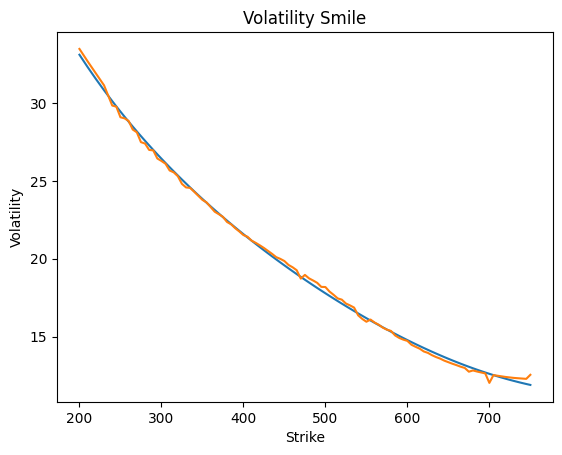

In [44]:
calibrated_vols = [
    sabr.lognormal_vol(strike, f, t, alpha, beta, rho, volvol) * 100
    for strike in strikes
]
plt.plot(
    strikes, 
    calibrated_vols
)

plt.xlabel("Strike")
plt.ylabel("Volatility")
plt.title("Volatility Smile")
plt.plot(strikes, vols)
plt.show()

In [45]:
#assess the model error

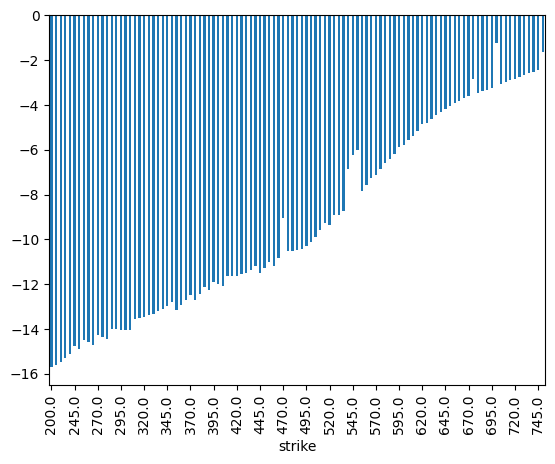

In [46]:
black_values = []
for strike, calibrated_vol in zip(strikes.tolist(), calibrated_vols):
    black_value = lognormal_call(
        strike, 
        f, 
        t, 
        calibrated_vol / 100, 
        0.05, 
        cp="call"
    )
    black_values.append(black_value)


option_values = pd.DataFrame(
    {
        "black": black_values,
        "market": jan_2026_c.mid
    },
    index=strikes
)


(option_values.black - option_values.market).plot.bar()

# Adjust x-axis interval
plt.xticks(range(0, len(strikes), 5))  # Change '5' to any number that suits your needs

plt.show()

In [32]:
#The result is a bar chart which demonstrates the model error for each strike price 
#based on the calibrated implied volatility from the SABR model.